In [1]:
import sys, os
import pathlib

import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
sys.path.append(str(pathlib.Path().resolve().parent))

In [3]:
from gradient_boosting_meta_tree import metatree, normal

In [4]:
SEED = 0
rng = np.random.default_rng(SEED)

# 人工データ作成

## 生成モデルの作成

In [5]:
SUBMODEL = normal
C_DIM_CONTINUOUS = 0
C_DIM_CATEGORICAL = 10
c_max_depth_genmodel = 5 # オプション2
h0_split_genmodel = 1.
sub_h_params_genmodel = {
    'tau': 1e1,
    'h_m': 0.0,
    'h_tau': 1e0,
    'known_precision': True,
}
DATA_SIZE = 2000
TRAIN_DATA_SIZE = 1000
TEST_DATA_SIZE = 1000
FLAG_PLOT = False # True: visualize the data pair-plot from the first model, super heavy...

In [6]:
condition_dict = {
    'C_DIM_CONTINUOUS': C_DIM_CONTINUOUS,
    'C_DIM_CATEGORICAL': C_DIM_CATEGORICAL,
    'c_max_depth_genmodel': c_max_depth_genmodel,
    'h0_split_genmodel': h0_split_genmodel,
    'sub_h_params': sub_h_params_genmodel,
    'DATA_SIZE': DATA_SIZE,
    'SEED': SEED,
}

In [7]:
# exp_decay on h_split
# h_split_list = np.array([h0_split_genmodel**i for i in range(1,c_max_depth_genmodel+1)] + [0.])
# fixed h_split
h_split_list = np.array([h0_split_genmodel]*c_max_depth_genmodel + [0.])
gentree = metatree.MetaTreeGenModel(
    SubModel=SUBMODEL,
    c_dim_continuous = C_DIM_CONTINUOUS,
    c_dim_categorical = C_DIM_CATEGORICAL,
    c_max_depth = c_max_depth_genmodel,
    h_split=h_split_list,
    seed = SEED,
)
gentree.init_tree(max_depth=c_max_depth_genmodel, h_split=h_split_list, building_scheme='breadth_first')
gentree.set_h_params(
    sub_h_params=sub_h_params_genmodel,
    where='leaf',
)
gentree.gen_params()
num_leafnodes = gentree.num_leafnodes
max_depth_after_build = gentree.max_depth_after_build
num_leafnodes, max_depth_after_build

(32, 5)

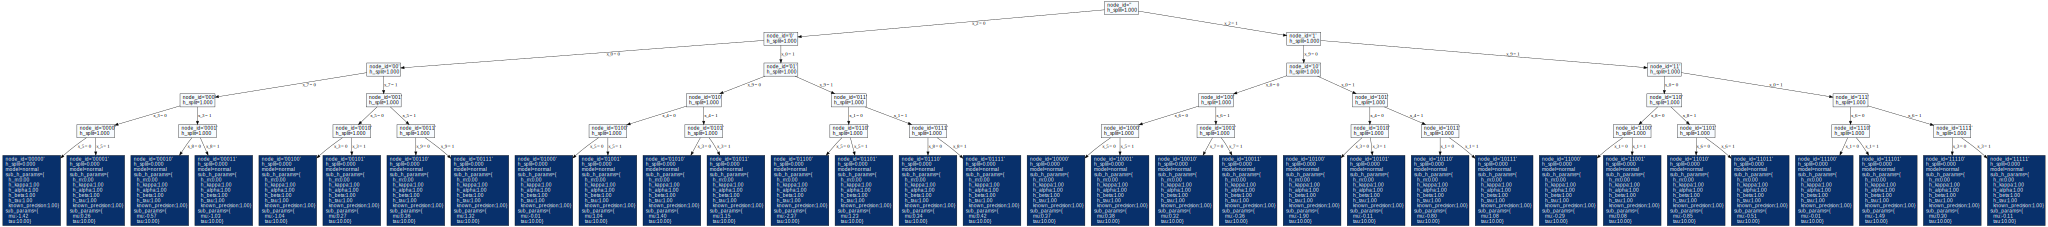

In [8]:
graph = gentree.visualize_model(view=False)
graph

In [9]:
true_feature_dict = gentree.get_split_rules()
true_feature_dict

{'': [2, None],
 '0': [0, None],
 '00': [7, None],
 '000': [3, None],
 '0000': [5, None],
 '0001': [8, None],
 '001': [5, None],
 '0010': [3, None],
 '0011': [9, None],
 '01': [9, None],
 '010': [4, None],
 '0100': [5, None],
 '0101': [3, None],
 '011': [1, None],
 '0110': [5, None],
 '0111': [8, None],
 '1': [9, None],
 '10': [0, None],
 '100': [6, None],
 '1000': [5, None],
 '1001': [7, None],
 '101': [4, None],
 '1010': [3, None],
 '1011': [1, None],
 '11': [0, None],
 '110': [8, None],
 '1100': [1, None],
 '1101': [6, None],
 '111': [6, None],
 '1110': [1, None],
 '1111': [3, None]}

## データの生成テスト

In [10]:
x_continuous,x_categorical,y,y_node_id= gentree.gen_sample(sample_size=DATA_SIZE)
x_continuous_train = x_continuous[:TRAIN_DATA_SIZE]
x_continuous_test = x_continuous[TRAIN_DATA_SIZE:]
x_categorical_train = x_categorical[:TRAIN_DATA_SIZE]
x_categorical_test = x_categorical[TRAIN_DATA_SIZE:]
y_train = y[:TRAIN_DATA_SIZE]
y_test = y[TRAIN_DATA_SIZE:]

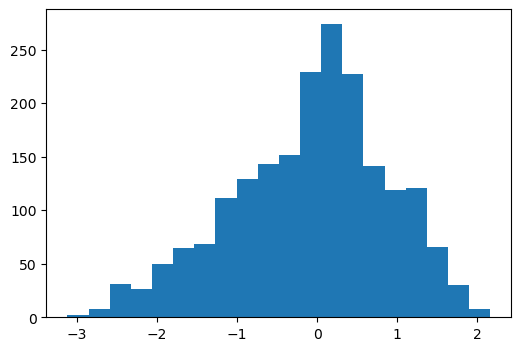

In [11]:
plt.figure(figsize=(6, 4))
plt.hist(y, bins=20, alpha=1, label='y')
plt.show()

In [12]:
y.std()

0.9720398254838964

## 学習と指標計算を行う関数作成

In [13]:
pathlib.Path().resolve()

PosixPath('/Users/1nao/GitHub/Gradient_Boosting_MetaTree/experiments')

In [14]:
from sklearn.metrics import mean_squared_error
from scipy.stats import sem

In [15]:
sub_h_params_learnmodel = {
    'h0_tau_x': sub_h_params_genmodel['tau'],
    'h0_m': sub_h_params_genmodel['h_m'],
    'h0_tau': sub_h_params_genmodel['h_tau'],
    'known_precision': True,
}
max_depth = 15
h0_split = 0.8
learning_rate = 0.5

In [16]:
MT_model_dict = {
    'model': metatree.MetaTreeLearnModel,
    'model_type': 'metatree',
    'init_params': {
        'SubModel': normal,
        'sub_h0_params': sub_h_params_learnmodel, # same to true-generative model
        'c_max_depth': max_depth,
        'h0_split': h0_split,
        'seed': SEED,
    },
    'build_params': {
        'split_strategy': 'best',
        'criterion': 'squared_error_leaf',
        'building_scheme': 'depth_first',
    }
}

In [17]:
MTCART_model_dict = {
    'model': metatree.MetaTreeLearnModel,
    'model_type': 'metatree',
    'init_params': {
        'SubModel': normal,
        'sub_h0_params': sub_h_params_learnmodel, # same to true-generative model
        'c_max_depth': max_depth,
        'h0_split': h0_split,
        'seed': SEED,
    },
    'build_params': {
        'split_strategy': 'copy_from_sklearn_tree',
        'criterion': 'squared_error_leaf',
        # 'building_scheme': 'depth_first',
    }
}

In [18]:
DT_model_dict = {
    'model': metatree.MetaTreeLearnModel,
    'model_type': 'metatree',
    'init_params': {
        'SubModel': normal,
        'sub_h0_params': sub_h_params_learnmodel, # same to true-generative model
        'c_max_depth': max_depth,
        'h0_split': 1.,
        'seed': SEED,
    },
    'build_params': {
        'split_strategy': 'best',
        'criterion': 'squared_error_leaf',
        'building_scheme': 'depth_first',
    }
}

## Define functions

In [19]:
from sklearn.tree import DecisionTreeRegressor
def learn_predict_manual_gb(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        num_tree,
        do_metatree: int, # 1: MT for all trees, 0: DT for the last tree, -1: DT for all trees
):
        data_info = {
                'c_dim_continuous': x_continuous_train.shape[1],
                'c_dim_categorical': x_categorical_train.shape[1],
        }
        x_train = np.concatenate([x_continuous_train, x_categorical_train], axis=1)
        x_test = np.concatenate([x_continuous_test, x_categorical_test], axis=1)
        MT_tree_list = [None for _ in range(num_tree)]
        DT_tree_list = [None for _ in range(num_tree)]
        hat_y_train_list = [None for _ in range(num_tree)]
        hat_y_test_list = [None for _ in range(num_tree)]
        train_residual_error_list_MT = [ _ for _ in range(num_tree)]
        train_residual_error_list_MTCART = [ _ for _ in range(num_tree)]
        train_residual_error_list_DT = [ _ for _ in range(num_tree)]
        train_residual_error_list_CART = [ _ for _ in range(num_tree)]
        train_residual_error_list_CARTccp0001 = [ _ for _ in range(num_tree)]
        train_residual_error_list_CARTccp0005 = [ _ for _ in range(num_tree)]
        train_residual_error_list_CARTccp001 = [ _ for _ in range(num_tree)]
        train_residual_error_list_CARTccp01 = [ _ for _ in range(num_tree)]
        test_residual_error_list_MT = [ _ for _ in range(num_tree)]
        test_residual_error_list_MTCART = [ _ for _ in range(num_tree)]
        test_residual_error_list_DT = [ _ for _ in range(num_tree)]
        test_residual_error_list_CART = [ _ for _ in range(num_tree)]
        test_residual_error_list_CARTccp0001 = [ _ for _ in range(num_tree)]
        test_residual_error_list_CARTccp0005 = [ _ for _ in range(num_tree)]
        test_residual_error_list_CARTccp001 = [ _ for _ in range(num_tree)]
        test_residual_error_list_CARTccp01 = [ _ for _ in range(num_tree)]

        residual_train = deepcopy(y_train)
        residual_test = deepcopy(y_test)
        for i in range(num_tree):
                # CART
                CART_model = DecisionTreeRegressor(max_depth=max_depth)
                CART_model.fit(x_train, residual_train)

                input_data = {
                        'x_continuous_vecs': x_continuous_train,
                        'x_categorical_vecs': x_categorical_train,
                        'y_vec': residual_train,
                }
                # MT model
                MT_init_inputs = {
                        **MT_model_dict['init_params'],
                        **data_info,
                }
                # MT_model_dict['build_params']['sklearn_tree'] = CART_model
                MT_build_inputs = {
                        **MT_model_dict['build_params'],
                        **input_data,
                }
                MT_model = MT_model_dict['model'](**MT_init_inputs)
                MT_model.build(**MT_build_inputs)
                MT_model.calc_pred_dist()
                MT_tree_list[i] = MT_model

                # MTCART model
                MTCART_init_inputs = {
                        **MTCART_model_dict['init_params'],
                        **data_info,
                }
                MTCART_model_dict['build_params']['sklearn_tree'] = CART_model
                MTCART_build_inputs = {
                        **MTCART_model_dict['build_params'],
                        **input_data,
                }
                MTCART_model = MTCART_model_dict['model'](**MTCART_init_inputs)
                MTCART_model.build(**MTCART_build_inputs)
                MTCART_model.calc_pred_dist()

                # DT model
                DT_init_inputs = {
                        **DT_model_dict['init_params'],
                        **data_info,
                }
                DT_model_dict['build_params']['sklearn_tree'] = CART_model
                DT_build_inputs = {
                        **DT_model_dict['build_params'],
                        **input_data,
                }
                DT_model = DT_model_dict['model'](**DT_init_inputs)
                DT_model.build(**DT_build_inputs)
                DT_model.calc_pred_dist()
                DT_tree_list[i] = DT_model

                # CART with ccp_alpha=0.001
                CARTccp0001_model = DecisionTreeRegressor(max_depth=max_depth, ccp_alpha=0.001)
                CARTccp0001_model.fit(x_train, residual_train)

                # CART with ccp_alpha=0.005
                CARTccp0005_model = DecisionTreeRegressor(max_depth=max_depth, ccp_alpha=0.005)
                CARTccp0005_model.fit(x_train, residual_train)

                # CART with ccp_alpha=0.01
                CARTccp001_model = DecisionTreeRegressor(max_depth=max_depth, ccp_alpha=0.01)
                CARTccp001_model.fit(x_train, residual_train)

                # CART with ccp_alpha=0.1
                CARTccp01_model = DecisionTreeRegressor(max_depth=max_depth, ccp_alpha=0.1)
                CARTccp01_model.fit(x_train, residual_train)


                hat_y_train_MT = MT_model.make_prediction(
                        x_continuous_train,
                        x_categorical_train,
                        loss='squared',
                )
                hat_y_test_MT = MT_model.make_prediction(
                        x_continuous_test,
                        x_categorical_test,
                        loss='squared',
                )
                hat_y_train_MTCART = MTCART_model.make_prediction(
                        x_continuous_train,
                        x_categorical_train,
                        loss='squared',
                )
                hat_y_test_MTCART = MTCART_model.make_prediction(
                        x_continuous_test,
                        x_categorical_test,
                        loss='squared',
                )
                hat_y_train_DT = DT_model.make_prediction(
                        x_continuous_train,
                        x_categorical_train,
                        loss='squared',
                )
                hat_y_test_DT = DT_model.make_prediction(
                        x_continuous_test,
                        x_categorical_test,
                        loss='squared',
                )
                hat_y_train_CART = CART_model.predict(x_train)
                hat_y_test_CART = CART_model.predict(x_test)
                hat_y_train_CARTccp0001 = CARTccp0001_model.predict(x_train)
                hat_y_test_CARTccp0001 = CARTccp0001_model.predict(x_test)
                hat_y_train_CARTccp0005 = CARTccp0005_model.predict(x_train)
                hat_y_test_CARTccp0005 = CARTccp0005_model.predict(x_test)
                hat_y_train_CARTccp001 = CARTccp001_model.predict(x_train)
                hat_y_test_CARTccp001 = CARTccp001_model.predict(x_test)
                hat_y_train_CARTccp01 = CARTccp01_model.predict(x_train)
                hat_y_test_CARTccp01 = CARTccp01_model.predict(x_test)

                hat_y_train_list[i] = hat_y_train_MT
                hat_y_test_list[i] = hat_y_test_MT
                train_residual_error_list_MT[i] = mean_squared_error(residual_train, hat_y_train_MT)
                test_residual_error_list_MT[i] = mean_squared_error(residual_test, hat_y_test_MT)
                train_residual_error_list_MTCART[i] = mean_squared_error(residual_train, hat_y_train_MTCART)
                test_residual_error_list_MTCART[i] = mean_squared_error(residual_test, hat_y_test_MTCART)
                train_residual_error_list_DT[i] = mean_squared_error(residual_train, hat_y_train_DT)
                test_residual_error_list_DT[i] = mean_squared_error(residual_test, hat_y_test_DT)
                train_residual_error_list_CART[i] = mean_squared_error(residual_train, hat_y_train_CART)
                test_residual_error_list_CART[i] = mean_squared_error(residual_test, hat_y_test_CART)
                train_residual_error_list_CARTccp0001[i] = mean_squared_error(residual_train, hat_y_train_CARTccp0001)
                test_residual_error_list_CARTccp0001[i] = mean_squared_error(residual_test, hat_y_test_CARTccp0001)
                train_residual_error_list_CARTccp0005[i] = mean_squared_error(residual_train, hat_y_train_CARTccp0005)
                test_residual_error_list_CARTccp0005[i] = mean_squared_error(residual_test, hat_y_test_CARTccp0005)
                train_residual_error_list_CARTccp001[i] = mean_squared_error(residual_train, hat_y_train_CARTccp001)
                test_residual_error_list_CARTccp001[i] = mean_squared_error(residual_test, hat_y_test_CARTccp001)
                train_residual_error_list_CARTccp01[i] = mean_squared_error(residual_train, hat_y_train_CARTccp01)
                test_residual_error_list_CARTccp01[i] = mean_squared_error(residual_test, hat_y_test_CARTccp01)

                residual_train -= hat_y_train_MT * learning_rate
                residual_test -= hat_y_test_MT * learning_rate

        hat_y_train = np.sum(np.array(hat_y_train_list), axis=0) * learning_rate       
        hat_y_test = np.sum(np.array(hat_y_test_list), axis=0) * learning_rate
        return hat_y_train, hat_y_test, \
                train_residual_error_list_MT, test_residual_error_list_MT, \
                train_residual_error_list_MTCART, test_residual_error_list_MTCART, \
                train_residual_error_list_DT, test_residual_error_list_DT, \
                train_residual_error_list_CART, test_residual_error_list_CART, \
                train_residual_error_list_CARTccp0001, test_residual_error_list_CARTccp0001, \
                train_residual_error_list_CARTccp0005, test_residual_error_list_CARTccp0005, \
                train_residual_error_list_CARTccp001, test_residual_error_list_CARTccp001, \
                train_residual_error_list_CARTccp01, test_residual_error_list_CARTccp01, \
                MT_tree_list

In [ ]:
# FIG_DIR = pathlib.Path().resolve() / 'metatree_experiment_code' / 'mlsp25' / 'figures'
# os.makedirs(FIG_DIR, exist_ok=True)

def learn_and_predict(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        data_roop_id,
        num_tree,
        do_metatree,
        visualize,
):
        hat_y_train, hat_y_test, \
        train_residual_error_list_MT, test_residual_error_list_MT, \
        train_residual_error_list_MTCART, test_residual_error_list_MTCART, \
        train_residual_error_list_DT, test_residual_error_list_DT, \
        train_residual_error_list_CART, test_residual_error_list_CART, \
        train_residual_error_list_CARTccp0001, test_residual_error_list_CARTccp0001, \
        train_residual_error_list_CARTccp0005, test_residual_error_list_CARTccp0005, \
        train_residual_error_list_CARTccp001, test_residual_error_list_CARTccp001, \
        train_residual_error_list_CARTccp01, test_residual_error_list_CARTccp01, \
        MT_tree_list = \
                learn_predict_manual_gb(
            x_continuous_train, x_categorical_train, y_train,
            x_continuous_test, x_categorical_test, y_test,
            num_tree,
            do_metatree=do_metatree,
        )

        if visualize:
                for i, learntree in enumerate(MT_tree_list):
                        tree_graph, _ = learntree.visualize_model(
                                view=False,
                        )
                        tree_graph.render(FIG_DIR / f'learntree_data{data_roop_id}_tree_{i}', format='png', cleanup=True)

        return hat_y_train, hat_y_test, \
                train_residual_error_list_MT, test_residual_error_list_MT, \
                train_residual_error_list_MTCART, test_residual_error_list_MTCART, \
                train_residual_error_list_DT, test_residual_error_list_DT, \
                train_residual_error_list_CART, test_residual_error_list_CART, \
                train_residual_error_list_CARTccp0001, test_residual_error_list_CARTccp0001, \
                train_residual_error_list_CARTccp0005, test_residual_error_list_CARTccp0005, \
                train_residual_error_list_CARTccp001, test_residual_error_list_CARTccp001, \
                train_residual_error_list_CARTccp01, test_residual_error_list_CARTccp01

In [21]:
def pred_measure_performance(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        data_roop_id,
        num_tree,
        do_metatree,
        visualize,
):
    hat_y_train, hat_y_test, \
    train_residual_error_list_MT, test_residual_error_list_MT, \
    train_residual_error_list_MTCART, test_residual_error_list_MTCART, \
    train_residual_error_list_DT, test_residual_error_list_DT, \
    train_residual_error_list_CART, test_residual_error_list_CART, \
    train_residual_error_list_CARTccp0001, test_residual_error_list_CARTccp0001, \
    train_residual_error_list_CARTccp0005, test_residual_error_list_CARTccp0005, \
    train_residual_error_list_CARTccp001, test_residual_error_list_CARTccp001, \
    train_residual_error_list_CARTccp01, test_residual_error_list_CARTccp01 = \
    learn_and_predict(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        data_roop_id=data_roop_id,
        num_tree=num_tree,
        do_metatree=do_metatree,
        visualize=visualize,
    )
    train_mse = mean_squared_error(y_train, hat_y_train)
    test_mse = mean_squared_error(y_test, hat_y_test)

    # # 最後の木の予測値がどれだけ残差に適合しているか計算
    # residual_train = deepcopy(y_train)
    # residual_test = deepcopy(y_test)
    # # 最後の木以外の予測値を引いていく
    # for i in range(num_tree):
    #     hat_y_train_tree = tree_list[i].make_prediction(
    #         x_continuous_train,
    #         x_categorical_train,
    #         loss='squared',
    #     )
    #     hat_y_test_tree = tree_list[i].make_prediction(
    #         x_continuous_test,
    #         x_categorical_test,
    #         loss='squared',
    #     )
    #     train_residual_error_list_each_tree[i] = deepcopy(mean_squared_error(residual_train, hat_y_train_tree))
    #     test_residual_error_list_each_tree[i] = deepcopy(mean_squared_error(residual_test, hat_y_test_tree))
    #     residual_train -= hat_y_train_tree * learning_rate
    #     residual_test -= hat_y_test_tree * learning_rate
    return train_mse, test_mse, \
            train_residual_error_list_MT, test_residual_error_list_MT, \
            train_residual_error_list_MTCART, test_residual_error_list_MTCART, \
            train_residual_error_list_DT, test_residual_error_list_DT, \
            train_residual_error_list_CART, test_residual_error_list_CART, \
            train_residual_error_list_CARTccp0001, test_residual_error_list_CARTccp0001, \
            train_residual_error_list_CARTccp0005, test_residual_error_list_CARTccp0005, \
            train_residual_error_list_CARTccp001, test_residual_error_list_CARTccp001, \
            train_residual_error_list_CARTccp01, test_residual_error_list_CARTccp01

In [22]:
def roop_data(
        gentree,
        num_data_roop,
        num_tree,
        # do_metatree,
        visualize,
        train_data_size,
        test_data_size,
):
        # train_mse_dict_data = {}
        # test_mse_dict_data = {}
        residuals_train_mse_each_tree_dict_data = {}
        residuals_test_mse_each_tree_dict_data = {}
        for modelname in ['MT', 'MTCART', 'DT', 'CART', 'CARTccp0001', 'CARTccp0005', 'CARTccp001', 'CARTccp01']:
                # train_mse_dict_data[modelname] = [None for _ in range(num_data_roop)]
                # test_mse_dict_data[modelname] = [None for _ in range(num_data_roop)]
                residuals_train_mse_each_tree_dict_data[modelname] = [None for _ in range(num_data_roop)]
                residuals_test_mse_each_tree_dict_data[modelname] = [None for _ in range(num_data_roop)]

        for i in range(num_data_roop):
                x_continuous,x_categorical,y,y_node_id= gentree.gen_sample(sample_size=train_data_size+test_data_size)
                x_continuous_train = x_continuous[:train_data_size]
                x_continuous_test = x_continuous[train_data_size:]
                x_categorical_train = x_categorical[:train_data_size]
                x_categorical_test = x_categorical[train_data_size:]
                y_train = y[:train_data_size]
                y_test = y[train_data_size:]
                
                train_mse, test_mse, \
                train_residual_error_list_MT, test_residual_error_list_MT, \
                train_residual_error_list_MTCART, test_residual_error_list_MTCART, \
                train_residual_error_list_DT, test_residual_error_list_DT, \
                train_residual_error_list_CART, test_residual_error_list_CART, \
                train_residual_error_list_CARTccp0001, test_residual_error_list_CARTccp0001, \
                train_residual_error_list_CARTccp0005, test_residual_error_list_CARTccp0005, \
                train_residual_error_list_CARTccp001, test_residual_error_list_CARTccp001, \
                train_residual_error_list_CARTccp01, test_residual_error_list_CARTccp01  = pred_measure_performance(
                        x_continuous_train, x_categorical_train, y_train,
                        x_continuous_test, x_categorical_test, y_test,
                        data_roop_id=i,
                        num_tree=num_tree,
                        do_metatree=1,
                        visualize=visualize,
                )
                
                residuals_train_mse_each_tree_dict_data['MT'][i] = deepcopy(train_residual_error_list_MT)
                residuals_test_mse_each_tree_dict_data['MT'][i] = deepcopy(test_residual_error_list_MT)
                residuals_train_mse_each_tree_dict_data['MTCART'][i] = deepcopy(train_residual_error_list_MTCART)
                residuals_test_mse_each_tree_dict_data['MTCART'][i] = deepcopy(test_residual_error_list_MTCART)
                residuals_train_mse_each_tree_dict_data['DT'][i] = deepcopy(train_residual_error_list_DT)
                residuals_test_mse_each_tree_dict_data['DT'][i] = deepcopy(test_residual_error_list_DT)
                residuals_train_mse_each_tree_dict_data['CART'][i] = deepcopy(train_residual_error_list_CART)
                residuals_test_mse_each_tree_dict_data['CART'][i] = deepcopy(test_residual_error_list_CART)
                residuals_train_mse_each_tree_dict_data['CARTccp0001'][i] = deepcopy(train_residual_error_list_CARTccp0001)
                residuals_test_mse_each_tree_dict_data['CARTccp0001'][i] = deepcopy(test_residual_error_list_CARTccp0001)
                residuals_train_mse_each_tree_dict_data['CARTccp0005'][i] = deepcopy(train_residual_error_list_CARTccp0005)
                residuals_test_mse_each_tree_dict_data['CARTccp0005'][i] = deepcopy(test_residual_error_list_CARTccp0005)
                residuals_train_mse_each_tree_dict_data['CARTccp001'][i] = deepcopy(train_residual_error_list_CARTccp001)
                residuals_test_mse_each_tree_dict_data['CARTccp001'][i] = deepcopy(test_residual_error_list_CARTccp001)
                residuals_train_mse_each_tree_dict_data['CARTccp01'][i] = deepcopy(train_residual_error_list_CARTccp01)
                residuals_test_mse_each_tree_dict_data['CARTccp01'][i] = deepcopy(test_residual_error_list_CARTccp01)
        return residuals_train_mse_each_tree_dict_data, residuals_test_mse_each_tree_dict_data

In [23]:
def roop_genmodel(
        num_gentree_roop,
        num_data_roop,
        num_tree,
        # do_metatree,
        visualize,
        train_data_size,
        test_data_size,
):
    # train_mse_dict_genmodel = {}
    # test_mse_dict_genmodel = {}
    residuals_train_mse_each_tree_dict_genmodel = {}
    residuals_test_mse_each_tree_dict_genmodel = {}
    for modelname in ['MT', 'MTCART', 'DT', 'CART', 'CARTccp0001', 'CARTccp0005', 'CARTccp001', 'CARTccp01']:
        # train_mse_dict_genmodel[modelname] = [None for _ in range(num_gentree_roop)]
        # test_mse_dict_genmodel[modelname] = [None for _ in range(num_gentree_roop)]
        residuals_train_mse_each_tree_dict_genmodel[modelname] = [None for _ in range(num_gentree_roop)]
        residuals_test_mse_each_tree_dict_genmodel[modelname] = [None for _ in range(num_gentree_roop)]
    for i in tqdm(range(num_gentree_roop), desc='gentree_roop', leave=False):
        gentree = metatree.MetaTreeGenModel(
            SubModel=SUBMODEL,
            c_dim_continuous = C_DIM_CONTINUOUS,
            c_dim_categorical = C_DIM_CATEGORICAL,
            c_max_depth = c_max_depth_genmodel,
            h_split=h_split_list,
            seed = SEED+i,
        )
        gentree.init_tree(max_depth=c_max_depth_genmodel, h_split=h_split_list, building_scheme='breadth_first')
        gentree.set_h_params(
            sub_h_params=sub_h_params_genmodel,
            where='leaf',
        )
        gentree.gen_params()
        residuals_train_mse_each_tree_dict_data, residuals_test_mse_each_tree_dict_data = roop_data(
            gentree,
            num_data_roop,
            num_tree,
            # do_metatree,
            visualize,
            train_data_size,
            test_data_size,
        )
        for modelname in ['MT', 'MTCART', 'DT', 'CART', 'CARTccp0001', 'CARTccp0005', 'CARTccp001', 'CARTccp01']:
            # train_mse_dict_genmodel[modelname][i] = train_mse_dict_data[modelname]
            # test_mse_dict_genmodel[modelname][i] = test_mse_dict_data[modelname]
            residuals_train_mse_each_tree_dict_genmodel[modelname][i] = residuals_train_mse_each_tree_dict_data[modelname]
            residuals_test_mse_each_tree_dict_genmodel[modelname][i] = residuals_test_mse_each_tree_dict_data[modelname]
    return residuals_train_mse_each_tree_dict_genmodel, residuals_test_mse_each_tree_dict_genmodel

## execute roops

In [24]:
num_gentree_roop = 5
num_data_roop = 2
visualize = False
train_data_size = 100
test_data_size = 1000

In [25]:
num_tree = 5

In [26]:
train_data_size_list = [
    # 50, 
    # 100, 
    # 200, 
    # 300, 
    # 400, 
    # 500,
    1000
    ]
# train_data_size_list = [50, 100, 150, 200]
# train_data_size_list = [10, 50]
res_dict = {}
for model_name in ['MT', 'MTCART', 'DT', 'CART', 'CARTccp0001', 'CARTccp0005', 'CARTccp001', 'CARTccp01']:
    res_dict[model_name] = {
        'train': {
            'mean': [],
            'sem': [],
        },
        'test': {
            'mean': [],
            'sem': [],
        },
        'residuals_train': {},
        'residuals_test': {},
    }
for i in range(num_tree):
    for model_name in ['MT', 'MTCART', 'DT', 'CART', 'CARTccp0001', 'CARTccp0005', 'CARTccp001', 'CARTccp01']:
        res_dict[model_name]['residuals_train'][f'tree_{i}'] = {
            'mean': [],
            'sem': [],
        }
        res_dict[model_name]['residuals_test'][f'tree_{i}'] = {
            'mean': [],
            'sem': [],
        }

In [27]:
bar1 = tqdm(train_data_size_list, desc='train_data_size')
for i, train_data_size in enumerate(train_data_size_list):
    residuals_train_mse_each_tree_dict_genmodel, residuals_test_mse_each_tree_dict_genmodel = roop_genmodel(
        num_gentree_roop=num_gentree_roop,
        num_data_roop=num_data_roop,
        num_tree=num_tree,
        visualize=visualize,
        train_data_size=train_data_size,
        test_data_size=test_data_size,
    )
    for modelname in ['MT', 'DT', 'MTCART', 'CART', 'CARTccp0001', 'CARTccp0005', 'CARTccp001', 'CARTccp01']:
        # res_dict[modelname]['train']['mean'].append(np.mean(np.array(train_mse_dict_genmodel[modelname]).flatten()))
        # res_dict[modelname]['train']['sem'].append(sem(np.array(train_mse_dict_genmodel[modelname]).flatten()))
        # res_dict[modelname]['test']['mean'].append(np.mean(np.array(test_mse_dict_genmodel[modelname]).flatten()))
        # res_dict[modelname]['test']['sem'].append(sem(np.array(test_mse_dict_genmodel[modelname]).flatten()))
        for j in range(num_tree):
            res_dict[modelname]['residuals_train'][f'tree_{j}']['mean'].append(np.mean(np.array(residuals_train_mse_each_tree_dict_genmodel[modelname])[:,:,j].flatten()))
            res_dict[modelname]['residuals_train'][f'tree_{j}']['sem'].append(sem(np.array(residuals_train_mse_each_tree_dict_genmodel[modelname])[:,:,j].flatten()))
            res_dict[modelname]['residuals_test'][f'tree_{j}']['mean'].append(np.mean(np.array(residuals_test_mse_each_tree_dict_genmodel[modelname])[:,:,j].flatten()))
            res_dict[modelname]['residuals_test'][f'tree_{j}']['sem'].append(sem(np.array(residuals_test_mse_each_tree_dict_genmodel[modelname])[:,:,j].flatten()))
    bar1.update(1)

train_data_size:   0%|          | 0/1 [00:00<?, ?it/s]

gentree_roop:   0%|          | 0/5 [00:00<?, ?it/s]

### tree number as xaxis

In [28]:
train_data_size = train_data_size_list[0]
train_data_size_idx = train_data_size_list.index(train_data_size)

In [29]:
treewise_statistics = {}
for modelname in ['MT', 'MTCART', 'DT', 'CART', 'CARTccp0001', 'CARTccp0005', 'CARTccp001', 'CARTccp01']:
    treewise_statistics[modelname] = {
        'train': {
            'mean': [res_dict[modelname]['residuals_train'][f'tree_{i}']['mean'][train_data_size_idx] for i in range(num_tree)],
            'sem': [res_dict[modelname]['residuals_train'][f'tree_{i}']['sem'][train_data_size_idx] for i in range(num_tree)],
        },
        'test': {
            'mean': [res_dict[modelname]['residuals_test'][f'tree_{i}']['mean'][train_data_size_idx] for i in range(num_tree)],
            'sem': [res_dict[modelname]['residuals_test'][f'tree_{i}']['sem'][train_data_size_idx] for i in range(num_tree)],
        },
    }

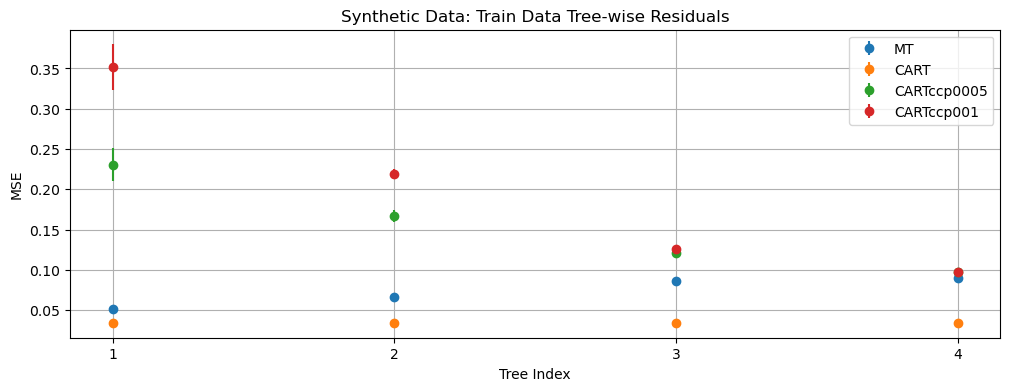

In [30]:
# plot tree-wise residuals: train data
plt.figure(figsize=(12, 4))
num_tree_viz = 4

for modelname in [
    'MT',
    # 'MTCART',
    # 'DT',
    'CART',
    # 'CARTccp0001',
    'CARTccp0005',
    'CARTccp001',
    # 'CARTccp01',
]:
    plt.errorbar(
        (np.array(range(num_tree))+1)[:num_tree_viz],
        treewise_statistics[modelname]['train']['mean'][:num_tree_viz],
        yerr=treewise_statistics[modelname]['train']['sem'][:num_tree_viz],
        fmt='o',
        label=modelname,
    )

plt.xticks((np.array(range(num_tree))+1)[:num_tree_viz])
plt.xlabel('Tree Index')
plt.ylabel('MSE')
plt.title('Synthetic Data: Train Data Tree-wise Residuals')
plt.legend()
plt.grid()

figpath = FIG_DIR / f'synthetic_tree-wise_residuals_train_{train_data_size}data.png'
# figpath = FIG_DIR / f'synthetic_tree-wise_residuals_train_cart.png'

# plt.savefig(figpath)

plt.show()

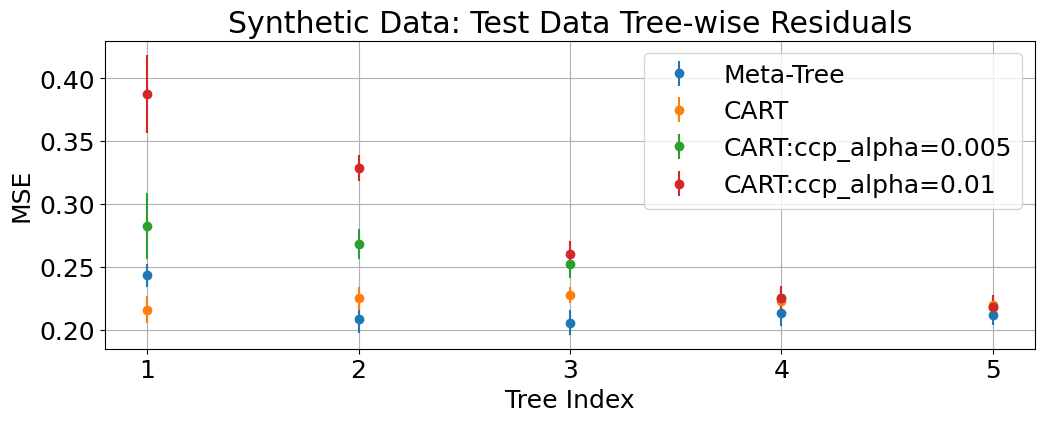

In [ ]:
# plot tree-wise residuals: test data
plt.rcParams.update({'font.size': 18})  # フォントサイズを設定

plt.figure(figsize=(12, 4))
num_tree_viz = 5

legend_name_map = {
    'MT': 'Meta-Tree',
    # 'MTCART': 'Meta-Tree with complete CART construction',
    'DT': 'Tree Model(Only with leaf-node priors)',
    'CART': 'CART',
    'CARTccp0001': 'CART:ccp_alpha=0.001',
    'CARTccp0005': 'CART:ccp_alpha=0.005',
    'CARTccp001': 'CART:ccp_alpha=0.01',
    'CARTccp01': 'CART:ccp_alpha=0.1',
}

for modelname in [
    'MT',
    # 'MTCART',
    # 'DT',
    'CART',
    # 'CARTccp0001',
    'CARTccp0005',
    'CARTccp001',
    # 'CARTccp01',
]:
    plt.errorbar(
        (np.array(range(num_tree))+1)[:num_tree_viz],
        treewise_statistics[modelname]['test']['mean'][:num_tree_viz],
        yerr=treewise_statistics[modelname]['test']['sem'][:num_tree_viz],
        fmt='o',
        label=legend_name_map[modelname],
    )

plt.xticks((np.array(range(num_tree))+1)[:num_tree_viz])
plt.xlabel('Tree Index')
plt.ylabel('MSE')
plt.title('Synthetic Data: Test Data Tree-wise Residuals')
plt.legend()
plt.grid()

figpath = FIG_DIR / f'synthetic_tree-wise_residuals_test_{train_data_size}data.png'

figpath = FIG_DIR / f'synthetic_tree-wise_residuals_test_{train_data_size}data_ccp.png'
# figpath = FIG_DIR / f'synthetic_tree-wise_residuals_test_cart.png'

# plt.savefig(figpath)

plt.show()

In [32]:
assert False

AssertionError: 

### sample size as xaxis

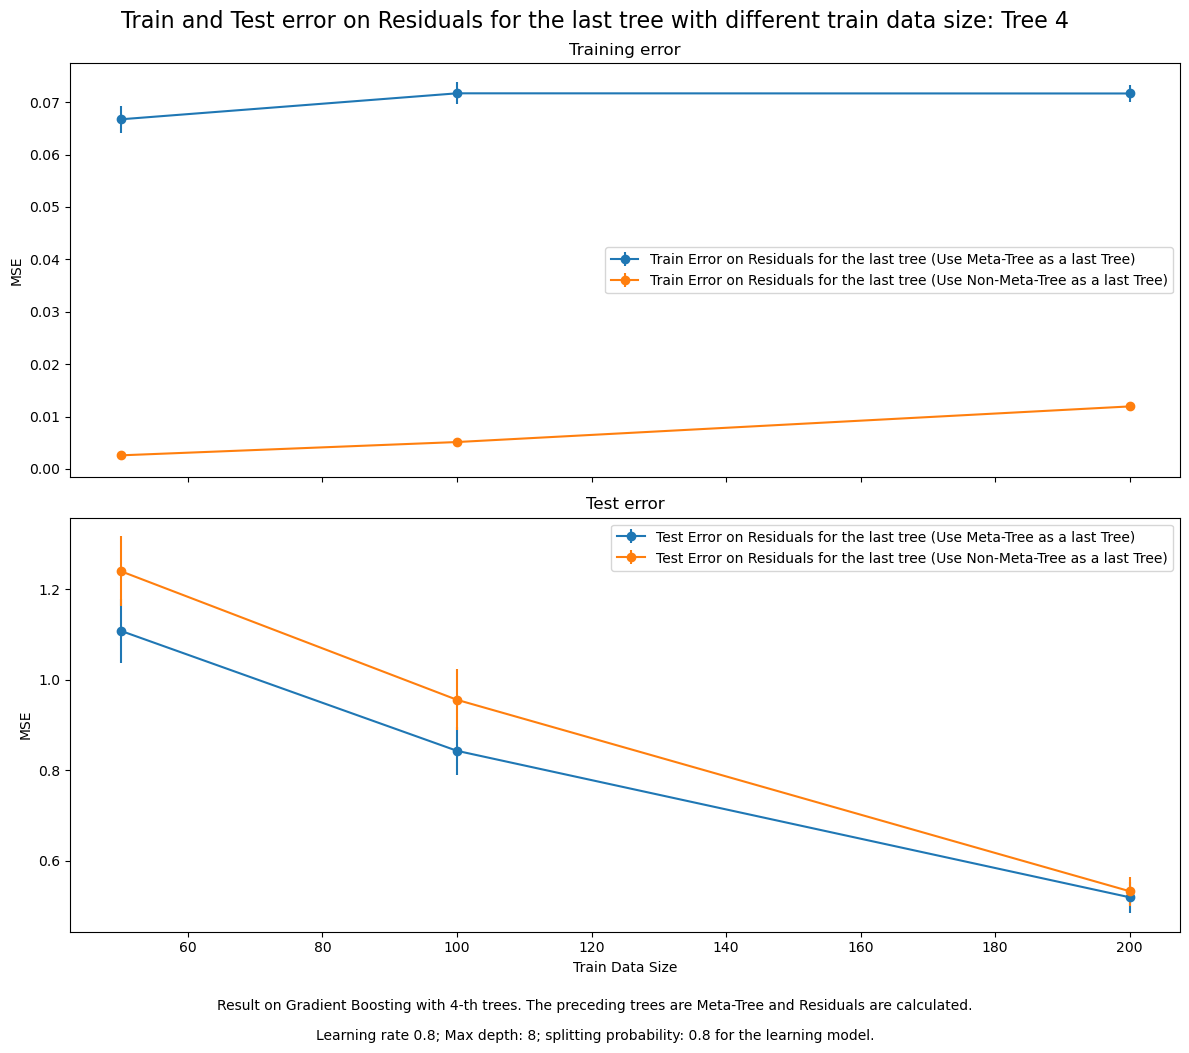

In [ ]:
i = 4
# Visualize the results from res_dict
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot for trainning error
ax[0].errorbar(train_data_size_list, res_dict['MT']['residuals_train'][f'tree_{i}']['mean'], yerr=res_dict['MT']['residuals_train'][f'tree_{i}']['sem'], label='Train Error on Residuals for the last tree (Use Meta-Tree as a last Tree)', fmt='-o')
ax[0].errorbar(train_data_size_list, res_dict['DT']['residuals_train'][f'tree_{i}']['mean'], yerr=res_dict['DT']['residuals_train'][f'tree_{i}']['sem'], label='Train Error on Residuals for the last tree (Use Non-Meta-Tree as a last Tree)', fmt='-o')
ax[0].set_title('Training error')
ax[0].set_ylabel('MSE')
ax[0].legend()

# Plot for Non-Meta-Tree
ax[1].errorbar(train_data_size_list, res_dict['MT']['residuals_test'][f'tree_{i}']['mean'], yerr=res_dict['MT']['residuals_test'][f'tree_{i}']['sem'], label='Test Error on Residuals for the last tree (Use Meta-Tree as a last Tree)', fmt='-o')
ax[1].errorbar(train_data_size_list, res_dict['DT']['residuals_test'][f'tree_{i}']['mean'], yerr=res_dict['DT']['residuals_test'][f'tree_{i}']['sem'], label='Test Error on Residuals for the last tree (Use Non-Meta-Tree as a last Tree)', fmt='-o')
ax[1].set_title('Test error')
ax[1].set_xlabel('Train Data Size')
ax[1].set_ylabel('MSE')
ax[1].legend()

# set title on the top
plt.subplots_adjust(top=0.9)
plt.suptitle(f'Train and Test error on Residuals for the last tree with different train data size: Tree {i}', fontsize=16)
# add caption at the bottom 2 lines.
text1 = f'Result on Gradient Boosting with {i}-th trees. The preceding trees are Meta-Tree and Residuals are calculated.'
plt.figtext(0.5, -0.02, text1, wrap=True, horizontalalignment='center', fontsize=10)
text2 = f'Learning rate {learning_rate}; Max depth: {max_depth}; splitting probability: {h0_split} for the learning model.'
plt.figtext(0.5, -0.05, text2, wrap=True, horizontalalignment='center', fontsize=10)
fig.tight_layout()
figpath = FIG_DIR / f'train_test_error_residuals_tree{i}.png'
# plt.savefig(figpath)
plt.show()

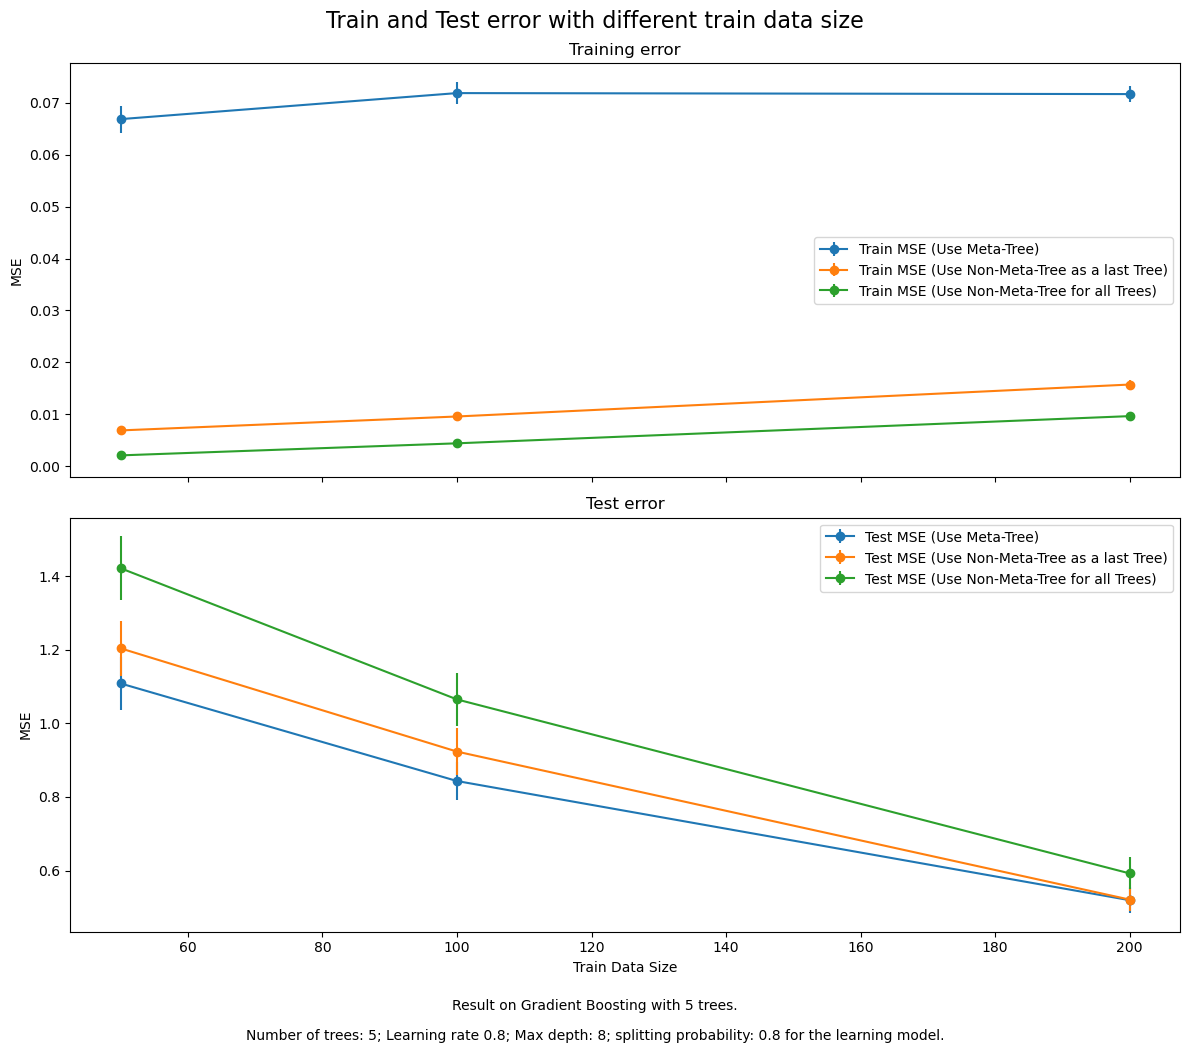

In [ ]:
# Visualize the results from res_dict
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot for trainning error
ax[0].errorbar(train_data_size_list, res_dict['MT']['train']['mean'], yerr=res_dict['MT']['train']['sem'], label='Train MSE (Use Meta-Tree)', fmt='-o')
ax[0].errorbar(train_data_size_list, res_dict['DT']['train']['mean'], yerr=res_dict['DT']['train']['sem'], label='Train MSE (Use Non-Meta-Tree as a last Tree)', fmt='-o')
ax[0].errorbar(train_data_size_list, res_dict['all_DT']['train']['mean'], yerr=res_dict['all_DT']['train']['sem'], label='Train MSE (Use Non-Meta-Tree for all Trees)', fmt='-o')
ax[0].set_title('Training error')
ax[0].set_ylabel('MSE')
ax[0].legend()

# Plot for Non-Meta-Tree
ax[1].errorbar(train_data_size_list, res_dict['MT']['test']['mean'], yerr=res_dict['MT']['test']['sem'], label='Test MSE (Use Meta-Tree)', fmt='-o')
ax[1].errorbar(train_data_size_list, res_dict['DT']['test']['mean'], yerr=res_dict['DT']['test']['sem'], label='Test MSE (Use Non-Meta-Tree as a last Tree)', fmt='-o')
ax[1].errorbar(train_data_size_list, res_dict['all_DT']['test']['mean'], yerr=res_dict['all_DT']['test']['sem'], label='Test MSE (Use Non-Meta-Tree for all Trees)', fmt='-o')
ax[1].set_title('Test error')
ax[1].set_xlabel('Train Data Size')
ax[1].set_ylabel('MSE')
ax[1].legend()

# set title on the top
plt.subplots_adjust(top=0.9)
plt.suptitle('Train and Test error with different train data size', fontsize=16)
# add caption at the bottom 2 lines.
text1 = f'Result on Gradient Boosting with {num_tree} trees.'
plt.figtext(0.5, -0.02, text1, wrap=True, horizontalalignment='center', fontsize=10)
text2 = f'Number of trees: {num_tree}; Learning rate {learning_rate}; Max depth: {max_depth}; splitting probability: {h0_split} for the learning model.'
plt.figtext(0.5, -0.05, text2, wrap=True, horizontalalignment='center', fontsize=10)
fig.tight_layout()
figpath = FIG_DIR / f'train_test_error_boosting_{num_tree}trees.png'
# plt.savefig(figpath)
plt.show()